# SDAB Melting Temperature Prediction using DL

### Load Modules and Datasets

In [1]:
### Initialize seed for reproducibility
import numpy as np
np.random.seed(0)
import math

### Data Wrangling and Plots
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
import keras

2024-09-07 17:46:29.065143: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 17:46:29.089492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def split_biased(data, y, split_column='source', holdout_var = "Camel"):
    """
    Create a split that holds out one group and splits the other one.
    """
    # data set for training
    x_train_all = data[meta[split_column] != holdout_var]
    y_train_all = y[meta[split_column] != holdout_var]

    #data set for validation
    x_val = data[meta[split_column] == holdout_var]
    y_val = y[meta[split_column] == holdout_var]

    #train, test split
    x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test, x_val, y_val

### DL Model: Keras Sequential API for ANN

In [3]:
def create_model():
    model = Sequential([
        keras.layers.Dense(128, 
                           input_shape = (x.shape[1],), # input shape is the number of predictors
                           activation = 'relu'), # Input Layer
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(1, 
                           activation = 'linear') # If the NN is a regressor, then the output layer has a single node.
    ])
    
    model.compile(
        loss = 'mae',
        optimizer = 'adam',
        metrics= ['mae']
    )
    
    model.summary()

    return model

In [4]:
def compute_accuracies(model, x_test, y_test):
    """
    Compute the accuracies
    """

    mae = mean_absolute_error(y_test, model.predict(x_test))
    rmse = math.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    coeff_det=r2_score(y_test, model.predict(x_test))
    return mae, rmse, coeff_det
    

#### check diagnostics again

In [5]:
data = pd.read_csv("/home/bionets-og86asub/Documents/hackathon-bayer/sdab_data_master_list_t6.csv", header = None)
data.head()
meta = pd.read_csv('/home/bionets-og86asub/Documents/hackathon-bayer/earth-ml-sensitivity//data/augmented_metadata.tsv')
y = pd.read_excel("/home/bionets-og86asub/Documents/hackathon-bayer/TEMPRO/paper_results/sdab_data.xlsx")

y = y.tm
x = data

In [6]:
species = ['Llama', 'Unknown', 'Camel', 'Alpaca', 'Human', 'Arabian camel (Camelus dromedarius)', 'Dromedary']
list_of_error = []
for animal in species:
    print(animal)
    x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column='source', holdout_var = animal)
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    model = create_model()
    model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
    mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
    list_of_error.append([animal, mae, rmse, coeff_det])

Llama


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 67.6160 - mae: 67.6160 - val_loss: 58.6189 - val_mae: 58.6189
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.4093 - mae: 55.4093 - val_loss: 22.8914 - val_mae: 22.8914
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.8315 - mae: 18.8315 - val_loss: 13.7577 - val_mae: 13.7577
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.7696 - mae: 11.7696 - val_loss: 11.7407 - val_mae: 11.7407
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.4448 - mae: 12.4448 - val_loss: 11.6619 - val_mae: 11.6619
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3427 - mae: 9.3427 - val_loss: 8.0150 - val_mae: 8.0150
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6357 - mae: 9.6357 - val_loss: 9.7879 - val_mae: 9.7879
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6322 - mae: 8.6322 - val_loss: 7.6488 - val_mae: 7.6488
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 62.5866 - mae: 62.5866 - val_loss: 20.6577 - val_mae: 20.6577
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.7602 - mae: 15.7602 - val_loss: 10.9952 - val_mae: 10.9952
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1194 - mae: 9.1194 - val_loss: 9.5452 - val_mae: 9.5452
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4590 - mae: 8.4590 - val_loss: 9.3340 - val_mae: 9.3340
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6203 - mae: 8.6203 - val_loss: 9.1025 - val_mae: 9.1025
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3644 - mae: 8.3644 - val_loss: 8.8411 - val_mae: 8.8411
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4457 - mae: 8.4457 - val_loss: 8.1388 - val_mae: 8.1388
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8364 - mae: 7.8364 - val_loss: 7.8413 - val_mae: 7.8413
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.8860 - mae: 64.8860 - val_loss: 56.7603 - val_mae: 56.7603
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9500 - mae: 44.9500 - val_loss: 17.8713 - val_mae: 17.8713
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.0055 - mae: 19.0055 - val_loss: 15.2998 - val_mae: 15.2998
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8419 - mae: 13.8419 - val_loss: 10.2184 - val_mae: 10.2184
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2190 - mae: 9.2190 - val_loss: 8.5772 - val_mae: 8.5772
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9869 - mae: 7.9869 - val_loss: 8.2427 - val_mae: 8.2427
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6126 - mae: 8.6126 - val_loss: 7.9658 - val_mae: 7.9658
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0535 - mae: 9.0535 - val_loss: 8.3952 - val_mae: 8.3952
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.4080 - mae: 64.4080 - val_loss: 33.3658 - val_mae: 33.3658
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.7688 - mae: 21.7688 - val_loss: 11.7318 - val_mae: 11.7318
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7580 - mae: 10.7580 - val_loss: 8.8287 - val_mae: 8.8287
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2975 - mae: 9.2975 - val_loss: 8.5980 - val_mae: 8.5980
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9304 - mae: 8.9304 - val_loss: 8.6094 - val_mae: 8.6094
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0838 - mae: 8.0838 - val_loss: 8.7230 - val_mae: 8.7230
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7993 - mae: 7.7993 - val_loss: 8.4329 - val_mae: 8.4329
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3206 - mae: 7.3206 - val_loss: 8.1339 - val_mae: 8.1339
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 63.2672 - mae: 63.2672 - val_loss: 24.6203 - val_mae: 24.6203
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.5794 - mae: 16.5794 - val_loss: 11.1664 - val_mae: 11.1664
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8086 - mae: 9.8086 - val_loss: 9.2191 - val_mae: 9.2191
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6148 - mae: 8.6148 - val_loss: 9.3372 - val_mae: 9.3372
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6452 - mae: 8.6452 - val_loss: 8.9718 - val_mae: 8.9718
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7907 - mae: 7.7907 - val_loss: 9.8980 - val_mae: 9.8980
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8807 - mae: 7.8807 - val_loss: 8.7546 - val_mae: 8.7546
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6813 - mae: 7.6813 - val_loss: 8.6070 - val_mae: 8.6070
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.0060 - mae: 64.0060 - val_loss: 24.2662 - val_mae: 24.2662
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.7253 - mae: 16.7253 - val_loss: 10.2560 - val_mae: 10.2560
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.2530 - mae: 10.2530 - val_loss: 9.3865 - val_mae: 9.3865
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6935 - mae: 8.6935 - val_loss: 9.0999 - val_mae: 9.0999
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4443 - mae: 8.4443 - val_loss: 8.5435 - val_mae: 8.5435
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1346 - mae: 8.1346 - val_loss: 8.3973 - val_mae: 8.3973
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6547 - mae: 7.6547 - val_loss: 8.2758 - val_mae: 8.2758
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4925 - mae: 7.4925 - val_loss: 8.1583 - val_mae: 8.1583
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 63.8581 - mae: 63.8581 - val_loss: 26.7424 - val_mae: 26.7424
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6053 - mae: 16.6053 - val_loss: 9.4346 - val_mae: 9.4346
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4992 - mae: 9.4992 - val_loss: 8.2860 - val_mae: 8.2860
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5390 - mae: 8.5390 - val_loss: 8.1728 - val_mae: 8.1728
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1609 - mae: 8.1609 - val_loss: 8.0445 - val_mae: 8.0445
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3279 - mae: 8.3279 - val_loss: 7.9122 - val_mae: 7.9122
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9612 - mae: 7.9612 - val_loss: 7.8641 - val_mae: 7.8641
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2780 - mae: 8.2780 - val_loss: 8.2419 - val_mae: 8.2419
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = create_model()
model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
list_of_error.append(['all', mae, rmse, coeff_det])

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.9684 - mae: 65.9684 - val_loss: 51.1468 - val_mae: 51.1468
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.6904 - mae: 36.6904 - val_loss: 10.6535 - val_mae: 10.6535
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6237 - mae: 10.6237 - val_loss: 10.1485 - val_mae: 10.1485
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8260 - mae: 8.8260 - val_loss: 8.3386 - val_mae: 8.3386
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4260 - mae: 8.4260 - val_loss: 8.1283 - val_mae: 8.1283
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7840 - mae: 8.7840 - val_loss: 8.3617 - val_mae: 8.3617
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2269 - mae: 8.2269 - val_loss: 8.0768 - val_mae: 8.0768
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7321 - mae: 7.7321 - val_loss: 7.7172 - val_mae: 7.7172
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [8]:
results = pd.DataFrame(list_of_error)
results.columns = ['Species', 'MAE', 'RMSE', 'R2']
df_melted = results.melt(id_vars='Species', value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [9]:
results

,Species,MAE,RMSE,R2
0,Llama,7.133596,8.895739,0.190013
1,Unknown,11.210401,13.013270,0.049377
2,Camel,8.129668,9.712155,-0.081708
3,Alpaca,8.648899,9.858648,-0.252527
4,Human,4.543522,5.367816,0.318025
5,Arabian camel (Camelus dromedarius),5.763791,7.100047,-0.348266
6,Dromedary,5.734988,5.734988,NaN
7,all,6.335902,8.127002,0.410141


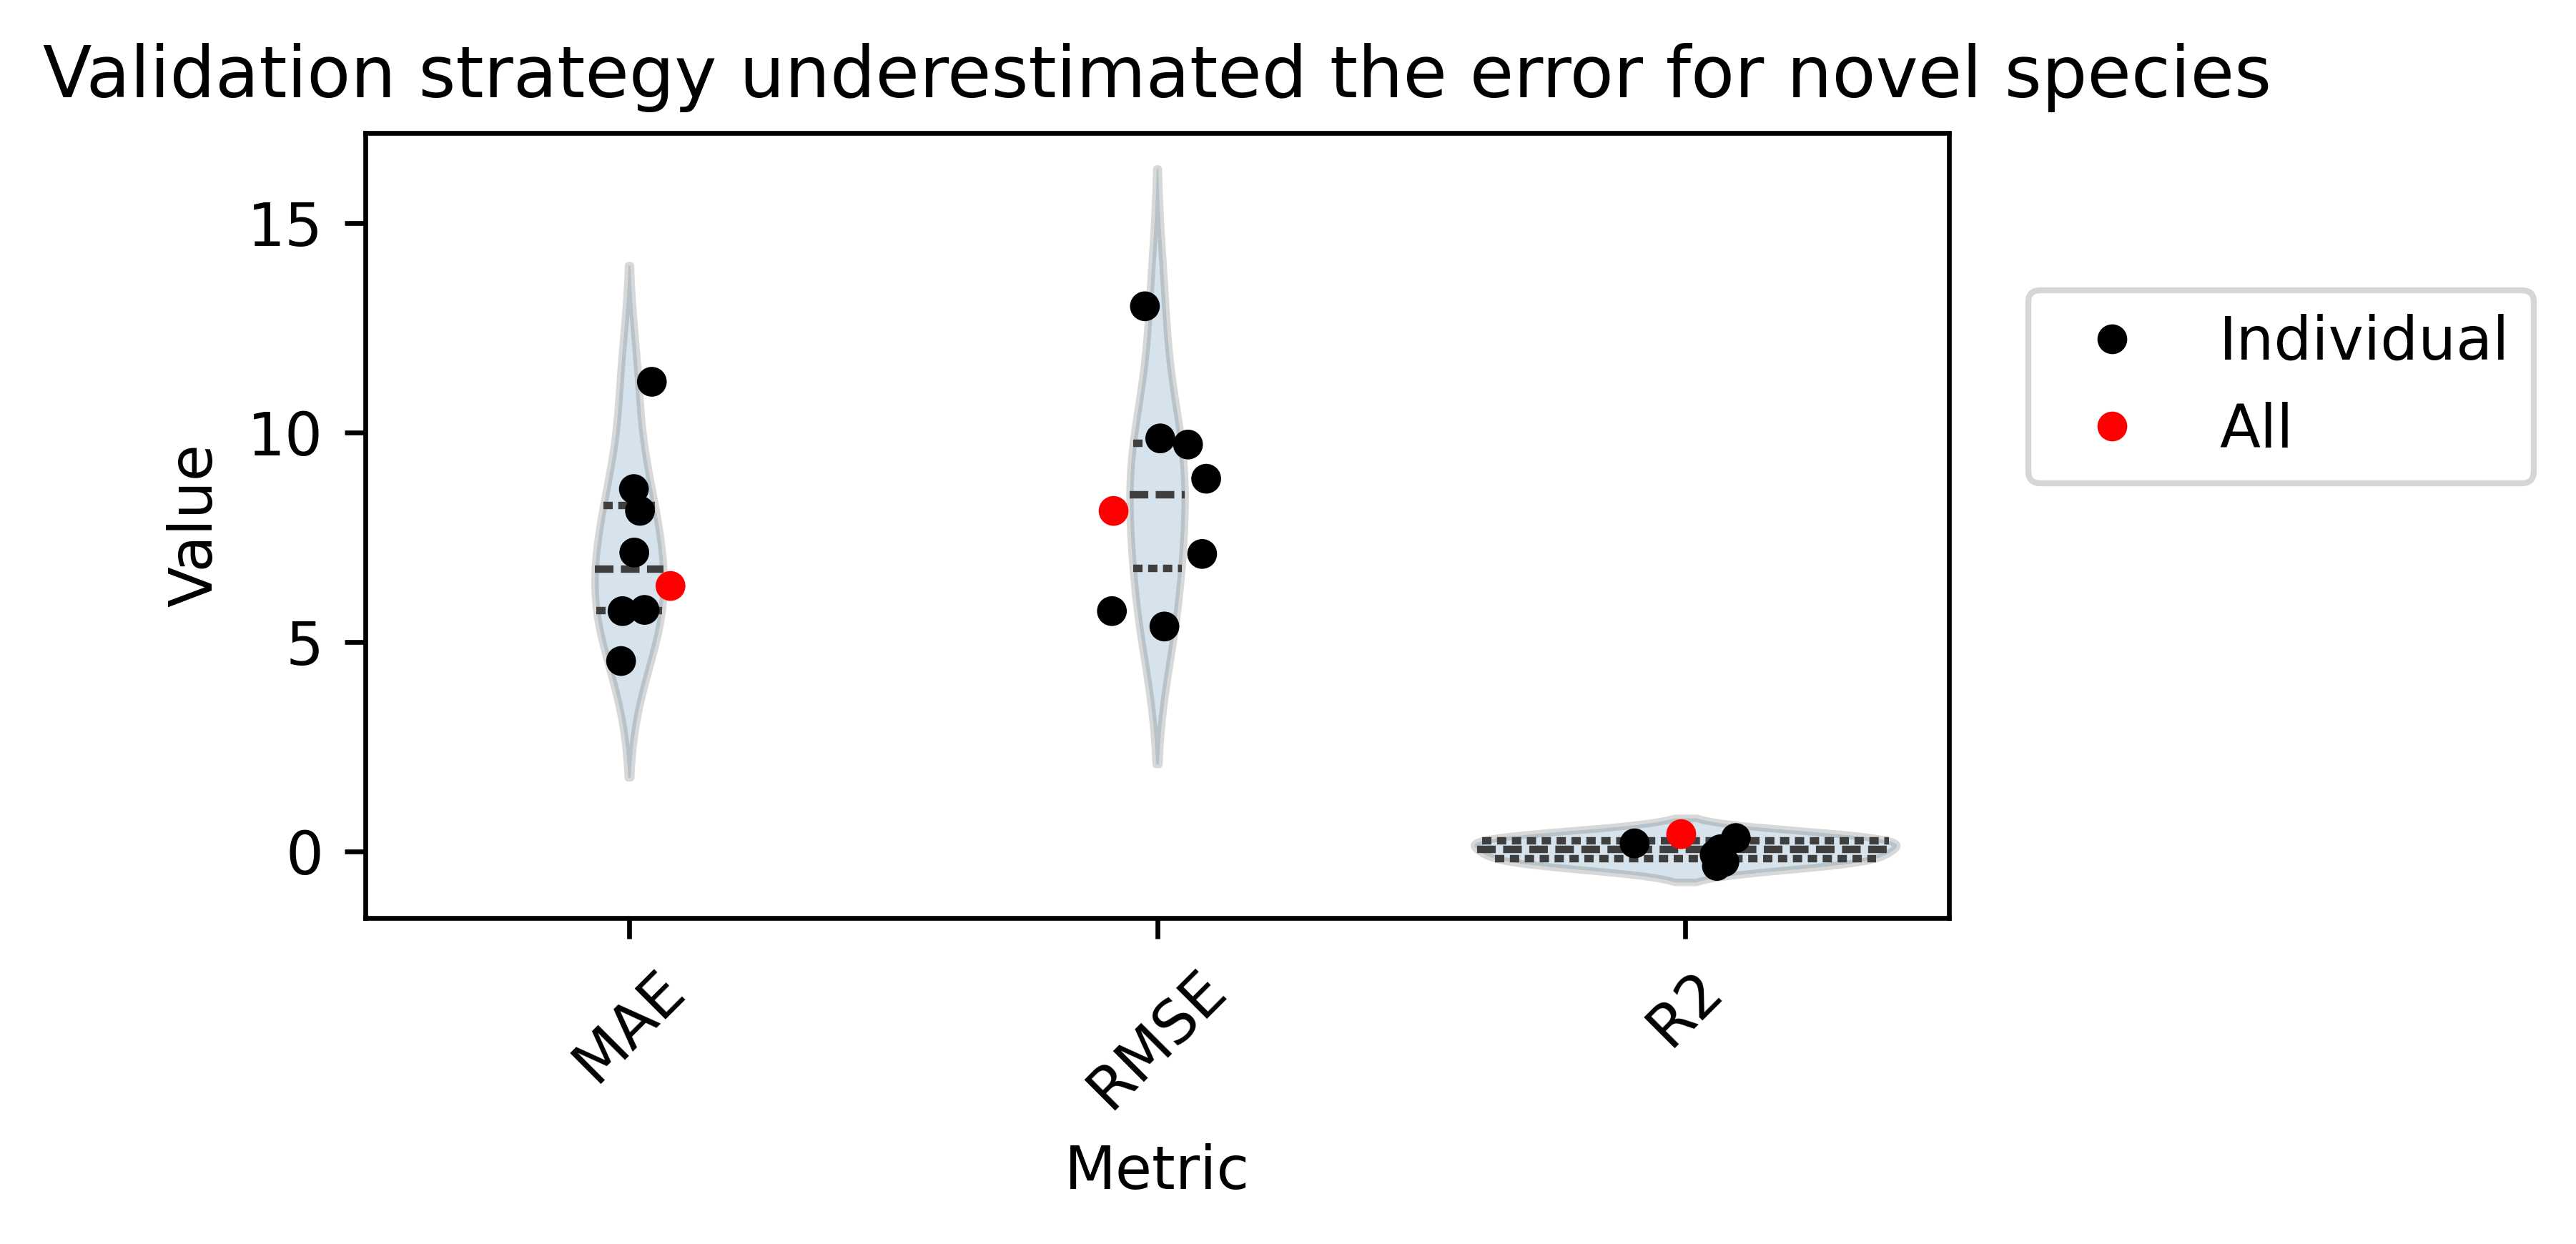

In [10]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' )
plt.title('Validation strategy underestimated the error for novel species')
plt.xticks(rotation=45)
sns.stripplot(
    x='Metric', y='Value', data=df_melted,
    hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
)

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = ['Individual', 'All']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(
    handles[:len(species_labels)]  , # Keep species and last 2 for colors
    species_labels + color_labels,                 # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

### Comute stats for homology splits

In [11]:
list_of_error = []
for column in [f'split_{i}' for i in range(2,5)]:
    for animal in meta[column].unique():
        print(animal)
        x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column=column, holdout_var = animal)
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        model = create_model()
        model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
        mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
        list_of_error.append([column, animal, mae, rmse, coeff_det])

0


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - loss: 76.6867 - mae: 76.6867 - val_loss: 77.4609 - val_mae: 77.4609
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 76.0264 - mae: 76.0264 - val_loss: 76.6819 - val_mae: 76.6819
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 75.3487 - mae: 75.3487 - val_loss: 75.3151 - val_mae: 75.3151
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 73.4849 - mae: 73.4849 - val_loss: 73.0463 - val_mae: 73.0463
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 71.1668 - mae: 71.1668 - val_loss: 69.2939 - val_mae: 69.2939
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 67.2175 - mae: 67.2175 - val_loss: 63.3010 - val_mae: 63.3010
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 60.9727 - mae: 60.9727 - val_loss: 54.0271 - val_mae: 54.0271
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 50.8085 - mae: 50.8085 - val_loss: 40.0220 - val_mae: 40.0220
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 61.9165 - mae: 61.9165 - val_loss: 35.7313 - val_mae: 35.7313
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.1565 - mae: 21.1565 - val_loss: 14.3790 - val_mae: 14.3790
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.4224 - mae: 13.4224 - val_loss: 8.4874 - val_mae: 8.4874
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4463 - mae: 8.4463 - val_loss: 8.3771 - val_mae: 8.3771
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0195 - mae: 8.0195 - val_loss: 7.8925 - val_mae: 7.8925
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5439 - mae: 7.5439 - val_loss: 7.6925 - val_mae: 7.6925
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1169 - mae: 8.1169 - val_loss: 7.4737 - val_mae: 7.4737
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6884 - mae: 7.6884 - val_loss: 7.5167 - val_mae: 7.5167
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 77.3272 - mae: 77.3272 - val_loss: 74.2590 - val_mae: 74.2590
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 76.1654 - mae: 76.1654 - val_loss: 73.1890 - val_mae: 73.1890
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 75.4439 - mae: 75.4439 - val_loss: 71.4294 - val_mae: 71.4294
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 73.8325 - mae: 73.8325 - val_loss: 68.5473 - val_mae: 68.5473
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 70.7277 - mae: 70.7277 - val_loss: 63.9479 - val_mae: 63.9479
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 65.5735 - mae: 65.5735 - val_loss: 56.7592 - val_mae: 56.7592
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 57.9504 - mae: 57.9504 - val_loss: 45.7759 - val_mae: 45.7759
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 46.3502 - mae: 46.3502 - val_loss: 29.5065 - val_mae: 29.5065
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 63.1611 - mae: 63.1611 - val_loss: 29.8532 - val_mae: 29.8532
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4808 - mae: 18.4808 - val_loss: 12.0944 - val_mae: 12.0944
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.0895 - mae: 10.0895 - val_loss: 9.5533 - val_mae: 9.5533
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5562 - mae: 8.5562 - val_loss: 9.3837 - val_mae: 9.3837
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0575 - mae: 9.0575 - val_loss: 8.6413 - val_mae: 8.6413
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5285 - mae: 8.5285 - val_loss: 8.2039 - val_mae: 8.2039
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9773 - mae: 7.9773 - val_loss: 8.8570 - val_mae: 8.8570
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3479 - mae: 8.3479 - val_loss: 8.6047 - val_mae: 8.6047
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 64.1232 - mae: 64.1232 - val_loss: 37.7884 - val_mae: 37.7884
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.9038 - mae: 23.9038 - val_loss: 11.4962 - val_mae: 11.4962
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.6605 - mae: 10.6605 - val_loss: 8.5991 - val_mae: 8.5991
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8303 - mae: 8.8303 - val_loss: 8.4339 - val_mae: 8.4339
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5878 - mae: 8.5878 - val_loss: 8.4903 - val_mae: 8.4903
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7471 - mae: 7.7471 - val_loss: 8.1784 - val_mae: 8.1784
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3060 - mae: 8.3060 - val_loss: 8.4347 - val_mae: 8.4347
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8073 - mae: 7.8073 - val_loss: 8.0519 - val_mae: 8.0519
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 73.8301 - mae: 73.8301 - val_loss: 71.2446 - val_mae: 71.2446
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 72.2600 - mae: 72.2600 - val_loss: 68.3808 - val_mae: 68.3808
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 68.3549 - mae: 68.3549 - val_loss: 62.2081 - val_mae: 62.2081
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 62.0365 - mae: 62.0365 - val_loss: 49.8990 - val_mae: 49.8990
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 48.3921 - mae: 48.3921 - val_loss: 26.8955 - val_mae: 26.8955
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23.1890 - mae: 23.1890 - val_loss: 14.4844 - val_mae: 14.4844
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.1890 - mae: 16.1890 - val_loss: 23.5372 - val_mae: 23.5372
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 18.4752 - mae: 18.4752 - val_loss: 7.6662 - val_mae: 7.6662
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 62.4017 - mae: 62.4017 - val_loss: 24.2309 - val_mae: 24.2309
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0609 - mae: 16.0609 - val_loss: 11.4824 - val_mae: 11.4824
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7323 - mae: 8.7323 - val_loss: 8.9516 - val_mae: 8.9516
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3628 - mae: 8.3628 - val_loss: 9.0419 - val_mae: 9.0419
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3618 - mae: 8.3618 - val_loss: 8.0963 - val_mae: 8.0963
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6497 - mae: 7.6497 - val_loss: 7.9525 - val_mae: 7.9525
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6743 - mae: 7.6743 - val_loss: 8.3411 - val_mae: 8.3411
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8123 - mae: 8.8123 - val_loss: 7.8931 - val_mae: 7.8931
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 63.5562 - mae: 63.5562 - val_loss: 31.8903 - val_mae: 31.8903
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.6463 - mae: 20.6463 - val_loss: 11.3285 - val_mae: 11.3285
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.0748 - mae: 10.0748 - val_loss: 8.7534 - val_mae: 8.7534
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4556 - mae: 9.4556 - val_loss: 9.3749 - val_mae: 9.3749
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4752 - mae: 8.4752 - val_loss: 8.4858 - val_mae: 8.4858
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3477 - mae: 8.3477 - val_loss: 9.0813 - val_mae: 9.0813
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2256 - mae: 8.2256 - val_loss: 8.6719 - val_mae: 8.6719
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5992 - mae: 8.5992 - val_loss: 8.1587 - val_mae: 8.1587
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.5678 - mae: 64.5678 - val_loss: 31.0012 - val_mae: 31.0012
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.1074 - mae: 20.1074 - val_loss: 10.8377 - val_mae: 10.8377
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7556 - mae: 9.7556 - val_loss: 8.3249 - val_mae: 8.3249
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6234 - mae: 8.6234 - val_loss: 8.2114 - val_mae: 8.2114
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1808 - mae: 8.1808 - val_loss: 8.1009 - val_mae: 8.1009
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1717 - mae: 8.1717 - val_loss: 7.9401 - val_mae: 7.9401
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5894 - mae: 7.5894 - val_loss: 7.9024 - val_mae: 7.9024
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9523 - mae: 7.9523 - val_loss: 7.7841 - val_mae: 7.7841
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = create_model()
model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
list_of_error.append(['all','all', mae, rmse, coeff_det])

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 65.0753 - mae: 65.0753 - val_loss: 41.2912 - val_mae: 41.2912
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.0512 - mae: 27.0512 - val_loss: 9.1409 - val_mae: 9.1409
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3451 - mae: 9.3451 - val_loss: 10.1105 - val_mae: 10.1105
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9071 - mae: 8.9071 - val_loss: 9.2826 - val_mae: 9.2826
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6766 - mae: 8.6766 - val_loss: 9.8084 - val_mae: 9.8084
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9745 - mae: 7.9745 - val_loss: 8.8335 - val_mae: 8.8335
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6146 - mae: 8.6146 - val_loss: 7.8508 - val_mae: 7.8508
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1515 - mae: 7.1515 - val_loss: 8.2220 - val_mae: 8.2220
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

In [13]:
results = pd.DataFrame(list_of_error)
results.columns = ['clusters','Species', 'MAE', 'RMSE', 'R2']

In [14]:
df_melted = results.melt(id_vars=['Species', 'clusters'], value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [15]:
df_melted

,Species,clusters,Metric,Value,color
0,0,split_2,MAE,11.274634,black
1,1,split_2,MAE,4.052053,black
2,0,split_3,MAE,12.597158,black
3,1,split_3,MAE,7.714956,black
4,2,split_3,MAE,10.126660,black
5,0,split_4,MAE,8.448465,black
6,3,split_4,MAE,9.604281,black
7,1,split_4,MAE,5.545713,black
8,2,split_4,MAE,6.295877,black
9,all,all,MAE,6.090791,red


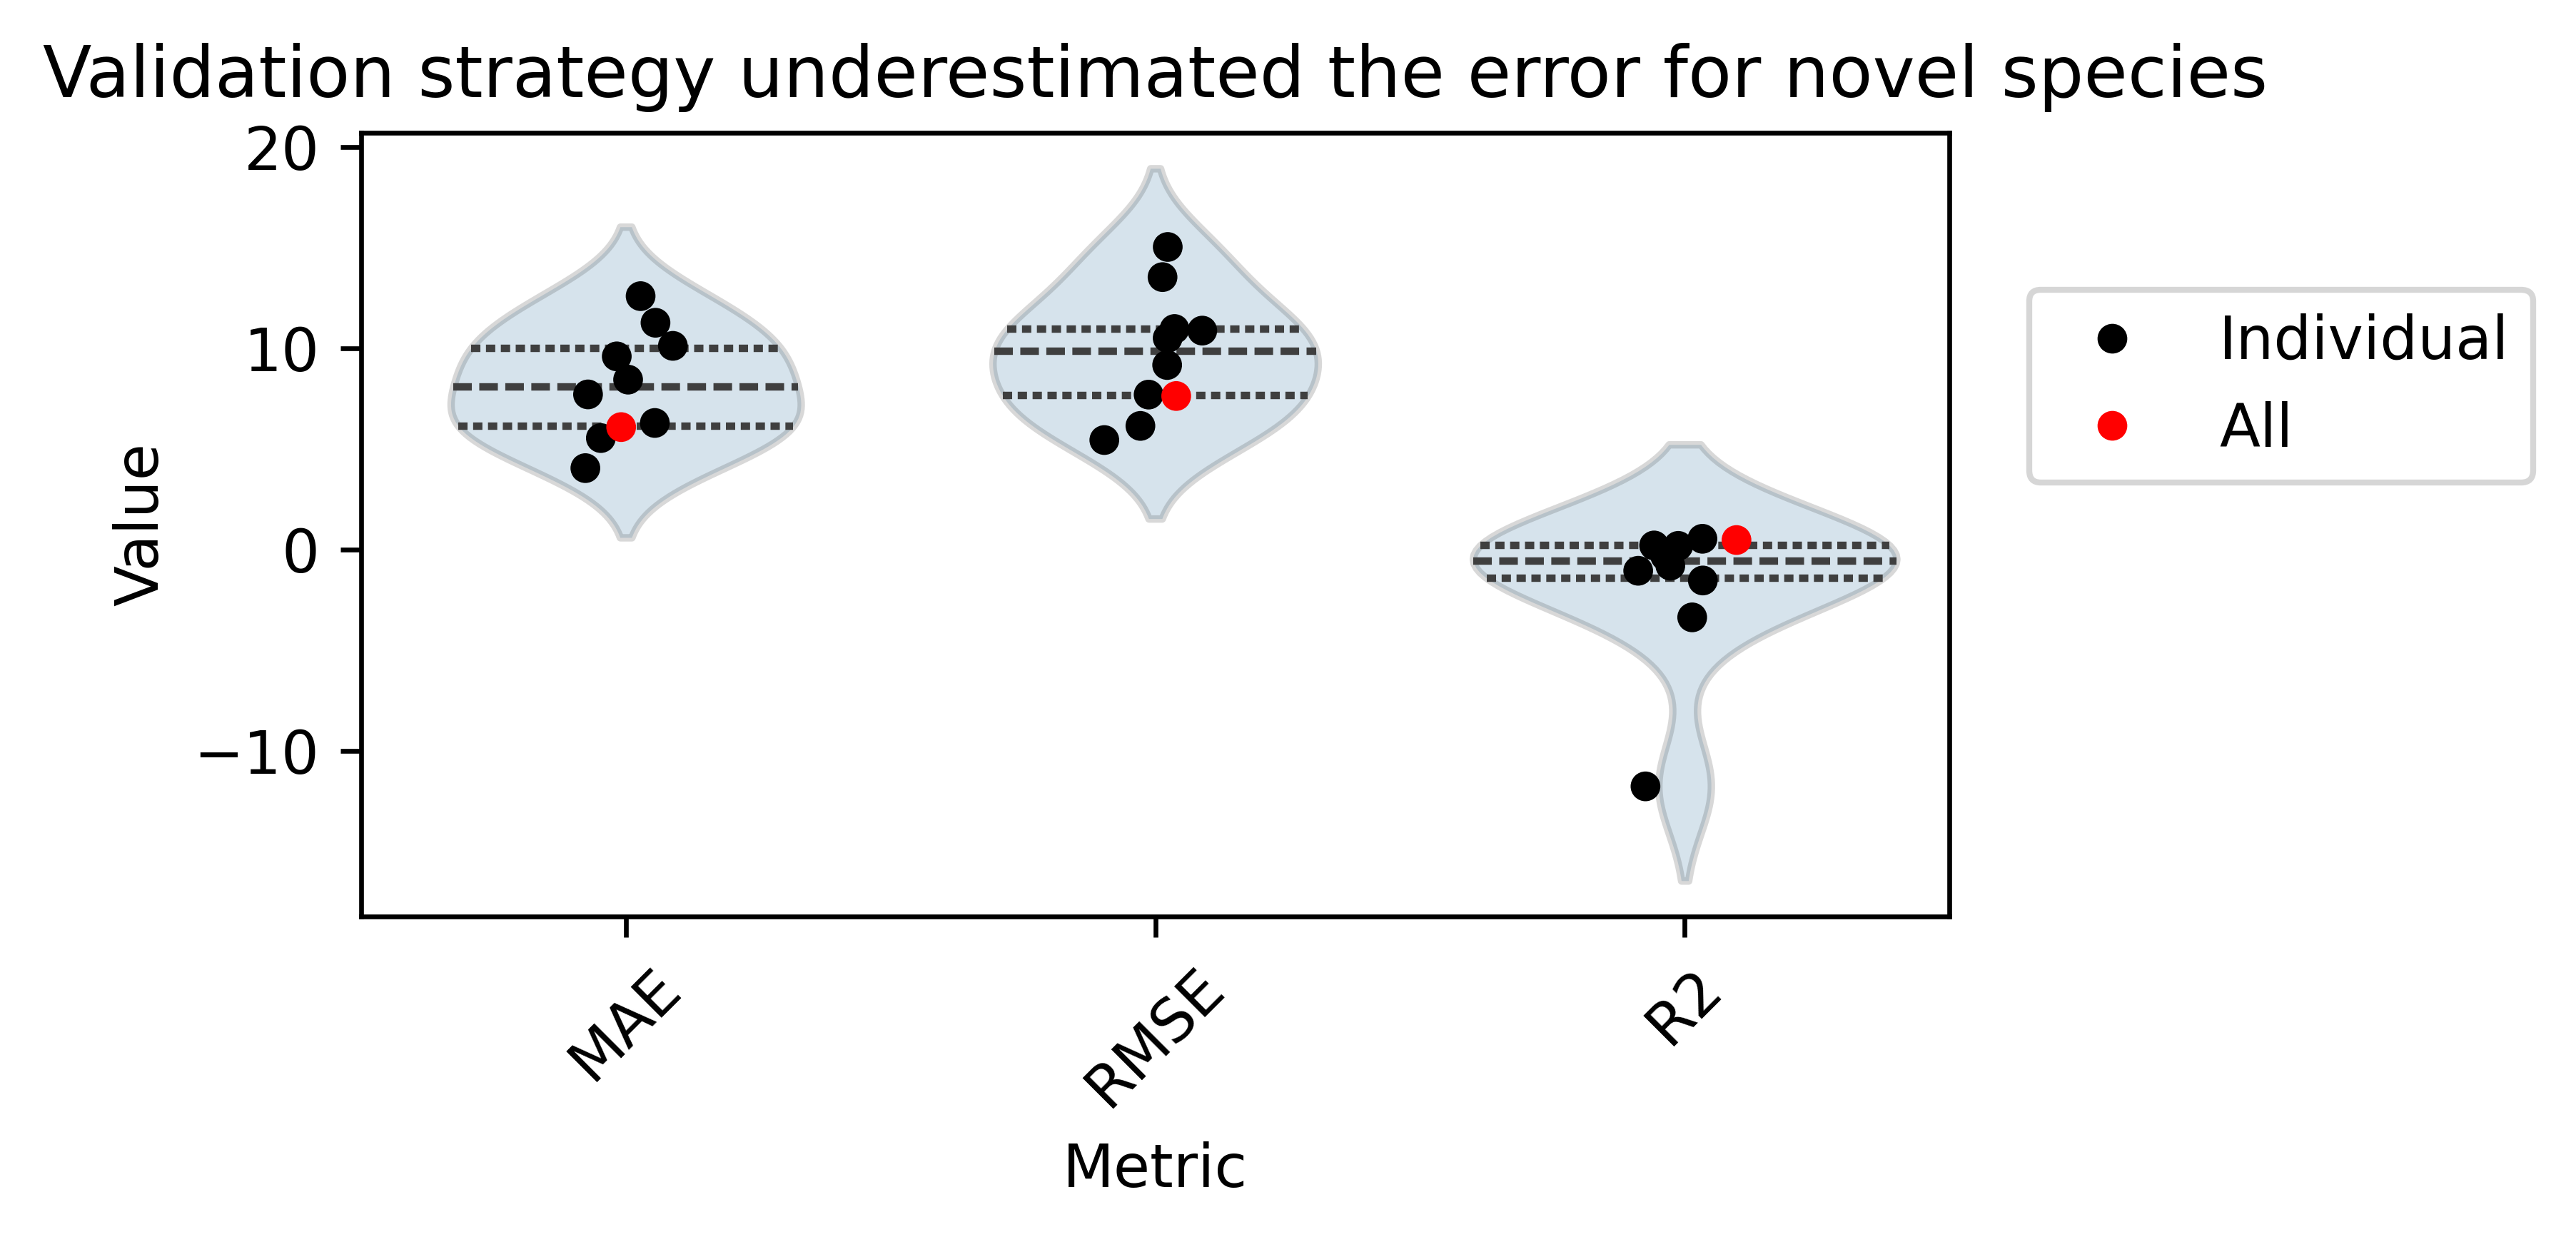

In [16]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' )
plt.title('Validation strategy underestimated the error for novel species')
plt.xticks(rotation=45)
sns.stripplot(
    x='Metric', y='Value', data=df_melted,
    hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
)

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = [ 'Individual', 'All']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(
    handles[:len(species_labels)]  , # Keep species and last 2 for colors
    species_labels + color_labels,                 # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.show()